The goal of this notebook is to qualitatively analyze the density profiles of Scl and the LMC and MW, and determine the jacobi tidal radius and required pericentres to induce a noticible tidal impact where we expect.

In [1]:
using CairoMakie 
using Arya

using LilGuys

In [2]:
using PythonCall
agama = pyimport("agama")

Python: <module 'agama' from '/cosma/home/durham/dc-boye1/.local/lib/python3.12/site-packages/agama/__init__.py'>

In [65]:
include(joinpath(ENV["DWARFS_ROOT"], "utils/agama_utils.jl"))

get_actions


Min(1) / Min(2) = rho_mean1 * r^3 / rho_mean2 * rh^3

In [4]:
potential_dir = ENV["DWARFS_ROOT"] * "/agama/potentials/"

"/cosma/home/durham/dc-boye1/data/dwarfs/agama/potentials/"

In [5]:
readdir(potential_dir )

23-element Vector{String}:
 "AS1991.ini"
 "BT08.ini"
 "Cautun20.ini"
 "EP2020.ini"
 "J95.ini"
 "README.md"
 "ablimit+2020.ini"
 "animation"
 "galpy_2014.ini"
 "gravitational_potentials.md"
 "irrgang13.ini"
 "mcmillan11.ini"
 "mcmillan17.ini"
 "nitschai+2020.ini"
 "nitschai+2021.ini"
 "piffl_14.ini"
 "pot"
 "pouliasis+2017.ini"
 "pouliasis+2017b.ini"
 "readme.txt"
 "vasiliev+21"
 "vasiliev23"
 "vasiliev24"

In [6]:
scl_profile = NFW(r_circ_max=1.84, v_circ_max=25.75/V2KMS)

NFW(0.06065872254457102, 0.8508349516179562, 28.21448458763477)

In [7]:
pot_lmc_2 = agama.Potential("$potential_dir/vasiliev24/L2M10/pot/lmc000.ini")

Python: Multipole (symmetry: None)

In [8]:
pot_lmc_3 = agama.Potential("$potential_dir/vasiliev24/L3M10/pot/lmc000.ini")

Python: Multipole (symmetry: None)

In [9]:
pot_lmc_1_5 = agama.Potential("$potential_dir/vasiliev+21/lmc00.pot")

Python: Multipole (symmetry: Spherical)

In [10]:
pot_MW_9_5 = agama.Potential("$potential_dir/vasiliev+21/potential_nolmc.ini")

Python: CompositePotential{ Multipole, DiskAnsatz, Multipole } (symmetry: Axisymmetric)

In [11]:
pot_MW_10 = agama.Potential("$potential_dir/vasiliev24/L2M10/potential_mw_init.ini")

Python: CompositePotential{ DiskAnsatz, Multipole } (symmetry: Axisymmetric)

In [12]:
pot_MW_11 = agama.Potential("$potential_dir/vasiliev24/L2M11/potential_mw_init.ini")

Python: CompositePotential{ DiskAnsatz, Multipole } (symmetry: Axisymmetric)

In [13]:
pot_EP = agama.Potential("$potential_dir/EP2020.ini")

Python: CompositePotential{ Dehnen, MiyamotoNagai, MiyamotoNagai, NFW } (symmetry: Axisymmetric)

In [14]:
function density_axis(gs)
    return Axis(gs[1,1],
        xlabel=L"log $r$ / kpc",
        ylabel = L"$\log\,\bar\rho / 10^{10}M_\odot$\,kpc$^{-3}$",
        )
end


density_axis (generic function with 1 method)

In [48]:
function calc_ρ_mean(prof::LilGuys.SphericalProfile, r)
    y = LilGuys.mass.(prof, r)
    rho_mean = @. y / (4π/3*r^3)
end

calc_ρ_mean (generic function with 2 methods)

In [16]:
function calc_ρ_mean(prof::Py, r; vasiliev_units=false)
    rho = prof.enclosedMass(np.array(r))
    M = pyconvert(Array{Float64}, rho) 
    if vasiliev_units
        M .*= V_M2MSUN ./ M2MSUN
    end

    y = @. M / (4π/3 * r^3)
end

calc_ρ_mean (generic function with 2 methods)

In [17]:
function plot_ρ_mean!(ax, prof::LilGuys.SphericalProfile)
    x = LinRange(-2, 1.5, 1000)
    r = 10 .^ x
    y = calc_ρ_mean(prof, r,)

    lines!(x, log10.(y))
end

plot_ρ_mean! (generic function with 1 method)

In [70]:
function plot_acc!(ax, prof::LilGuys.SphericalProfile)
    x = LinRange(-2, 1.5, 1000)
    r = 10 .^ x
    y = LilGuys.potential.(prof, r)
    rho_mean = LilGuys.gradient(y, r)

    lines!(x, log10.(rho_mean ./ r))
end

plot_acc! (generic function with 2 methods)

In [19]:
np = pyimport("numpy")

Python: <module 'numpy' from '/cosma/local/Python/3.12.4/lib/python3.12/site-packages/numpy/__init__.py'>

In [20]:
function plot_ρ_mean!(ax, prof::Py; xlimits=(-2, 1.5), vasiliev_units=false, kwargs...)
    x = LinRange(xlimits[1], xlimits[2], 1000)
    r = 10 .^ x
 
    y = calc_ρ_mean(prof, r, vasiliev_units=vasiliev_units)
    lines!(x, log10.(y); kwargs...)
end

plot_ρ_mean! (generic function with 2 methods)

In [72]:
function plot_acc!(ax, prof::Py; xlimits=(-2, 1.5), vasiliev_units=false, kwargs...)
    x = LinRange(xlimits[1], xlimits[2], 1000)
    r = np.array((10 .^ x) .* [0, 0, 1]')
    rho = prof.force(r)
    acc = pyconvert(Matrix{Float64}, rho)'
    a = radii(acc)
    r = 10 .^ x
    
    if vasiliev_units
        a .*= (V_M2MSUN ./ M2MSUN) ./ (V_T2GYR ./ T2GYR) .^ 2
    end

    lines!(x, log10.(a ./ r); kwargs...)
end

plot_acc! (generic function with 2 methods)

In [42]:
LilGuys.arcmin2kpc(30, 83.2)

0.726056968829641

In [43]:
sv = 9.6/ V2KMS
rh = 0.73
dlρ_mean = 0.2
ρ_mean = 5/3 * 3*sv^2 / (4π/3 * rh^2)

0.004799109251798657

In [67]:
-0.089*V_T2GYR

-0.08702331

In [68]:
50 * V_M2MSUN / M2MSUN * 3 .* (10 .^ (-dlρ_mean), 1, 10 .^ (dlρ_mean))

(0.002200463738874674, 0.0034874999999999997, 0.005527315008708133)

In [69]:
V_T2GYR

0.97779

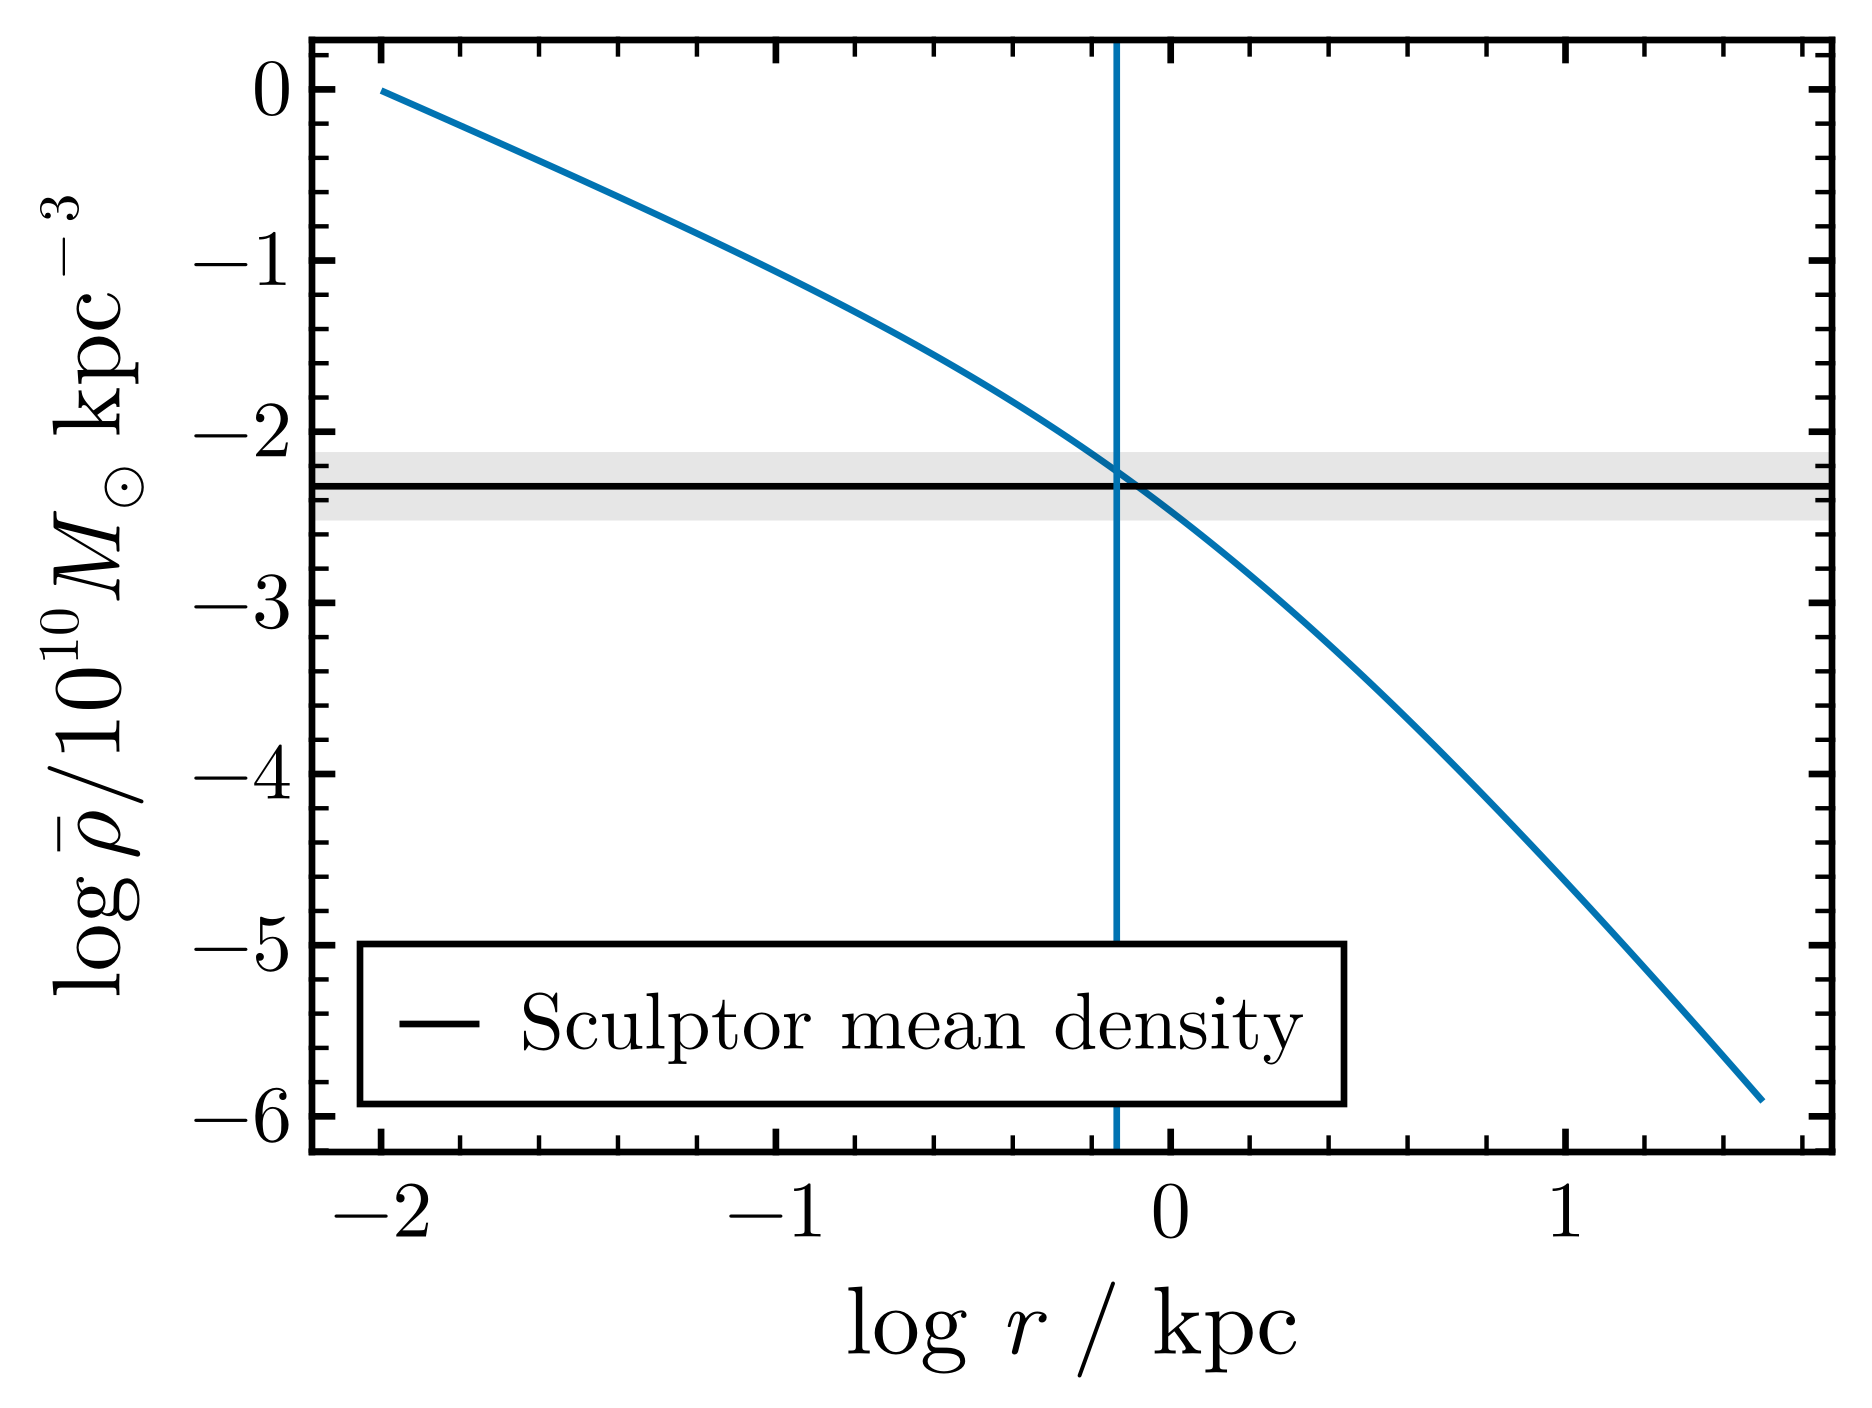

In [49]:
let
    fig = Figure()
    ax = density_axis(fig[1,1])

    plot_ρ_mean!(ax, scl_profile)

    hlines!(log10(ρ_mean), color=:black, label="Sculptor mean density")
    hspan!(log10(ρ_mean) - dlρ_mean, log10(ρ_mean) + dlρ_mean, color=(:black, 0.1))
    vlines!(log10(rh))
    axislegend(position=:lb)
    fig
end

In [50]:
let
    fig = Figure()
    ax = density_axis(fig[1,1])

    plot_acc!(ax, scl_profile)
    hlines!(log10.(3sv^2 / rh^2))

    fig
end

LoadError: UndefVarError: `calc_Φ` not defined in `LilGuys`
Suggestion: check for spelling errors or missing imports.

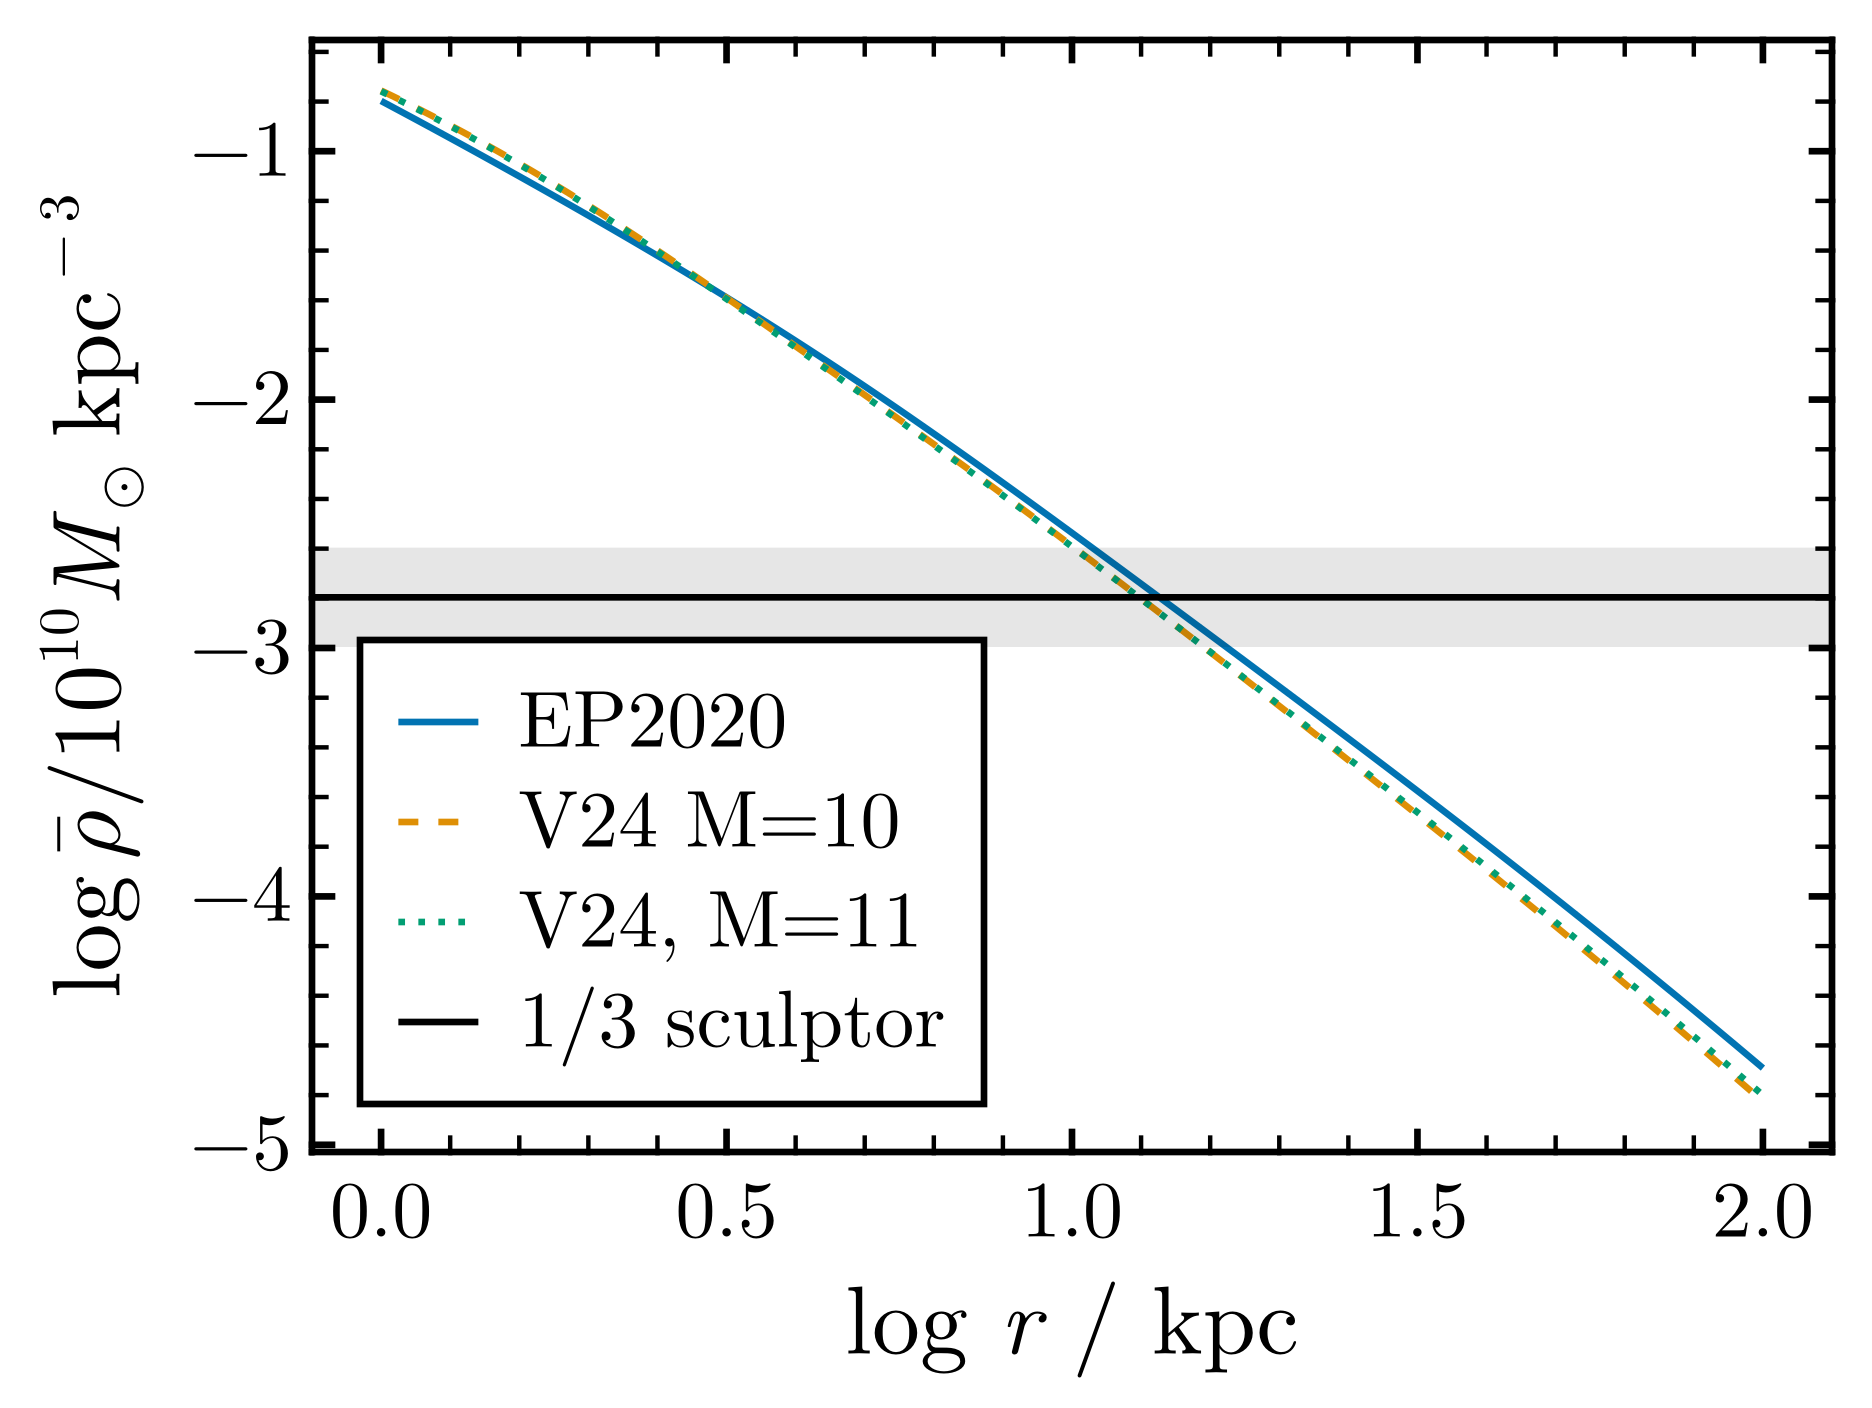

In [66]:
let
    fig = Figure()
    ax = density_axis(fig[1,1])

    plot_ρ_mean!(ax, pot_EP, xlimits=(0, 2), label="EP2020")
    plot_ρ_mean!(ax, pot_MW_10, xlimits=(0, 2), vasiliev_units=true, label="V24 M=10")
    plot_ρ_mean!(ax, pot_MW_11, xlimits=(0, 2), vasiliev_units=true, label="V24, M=11")

    hlines!(log10(ρ_mean/3), color=:black, label="1/3 sculptor")
    hspan!(log10(ρ_mean/3) - dlρ_mean, log10(ρ_mean/3) + dlρ_mean, color=(:black, 0.1))

    axislegend(position=:lb)
    fig
end

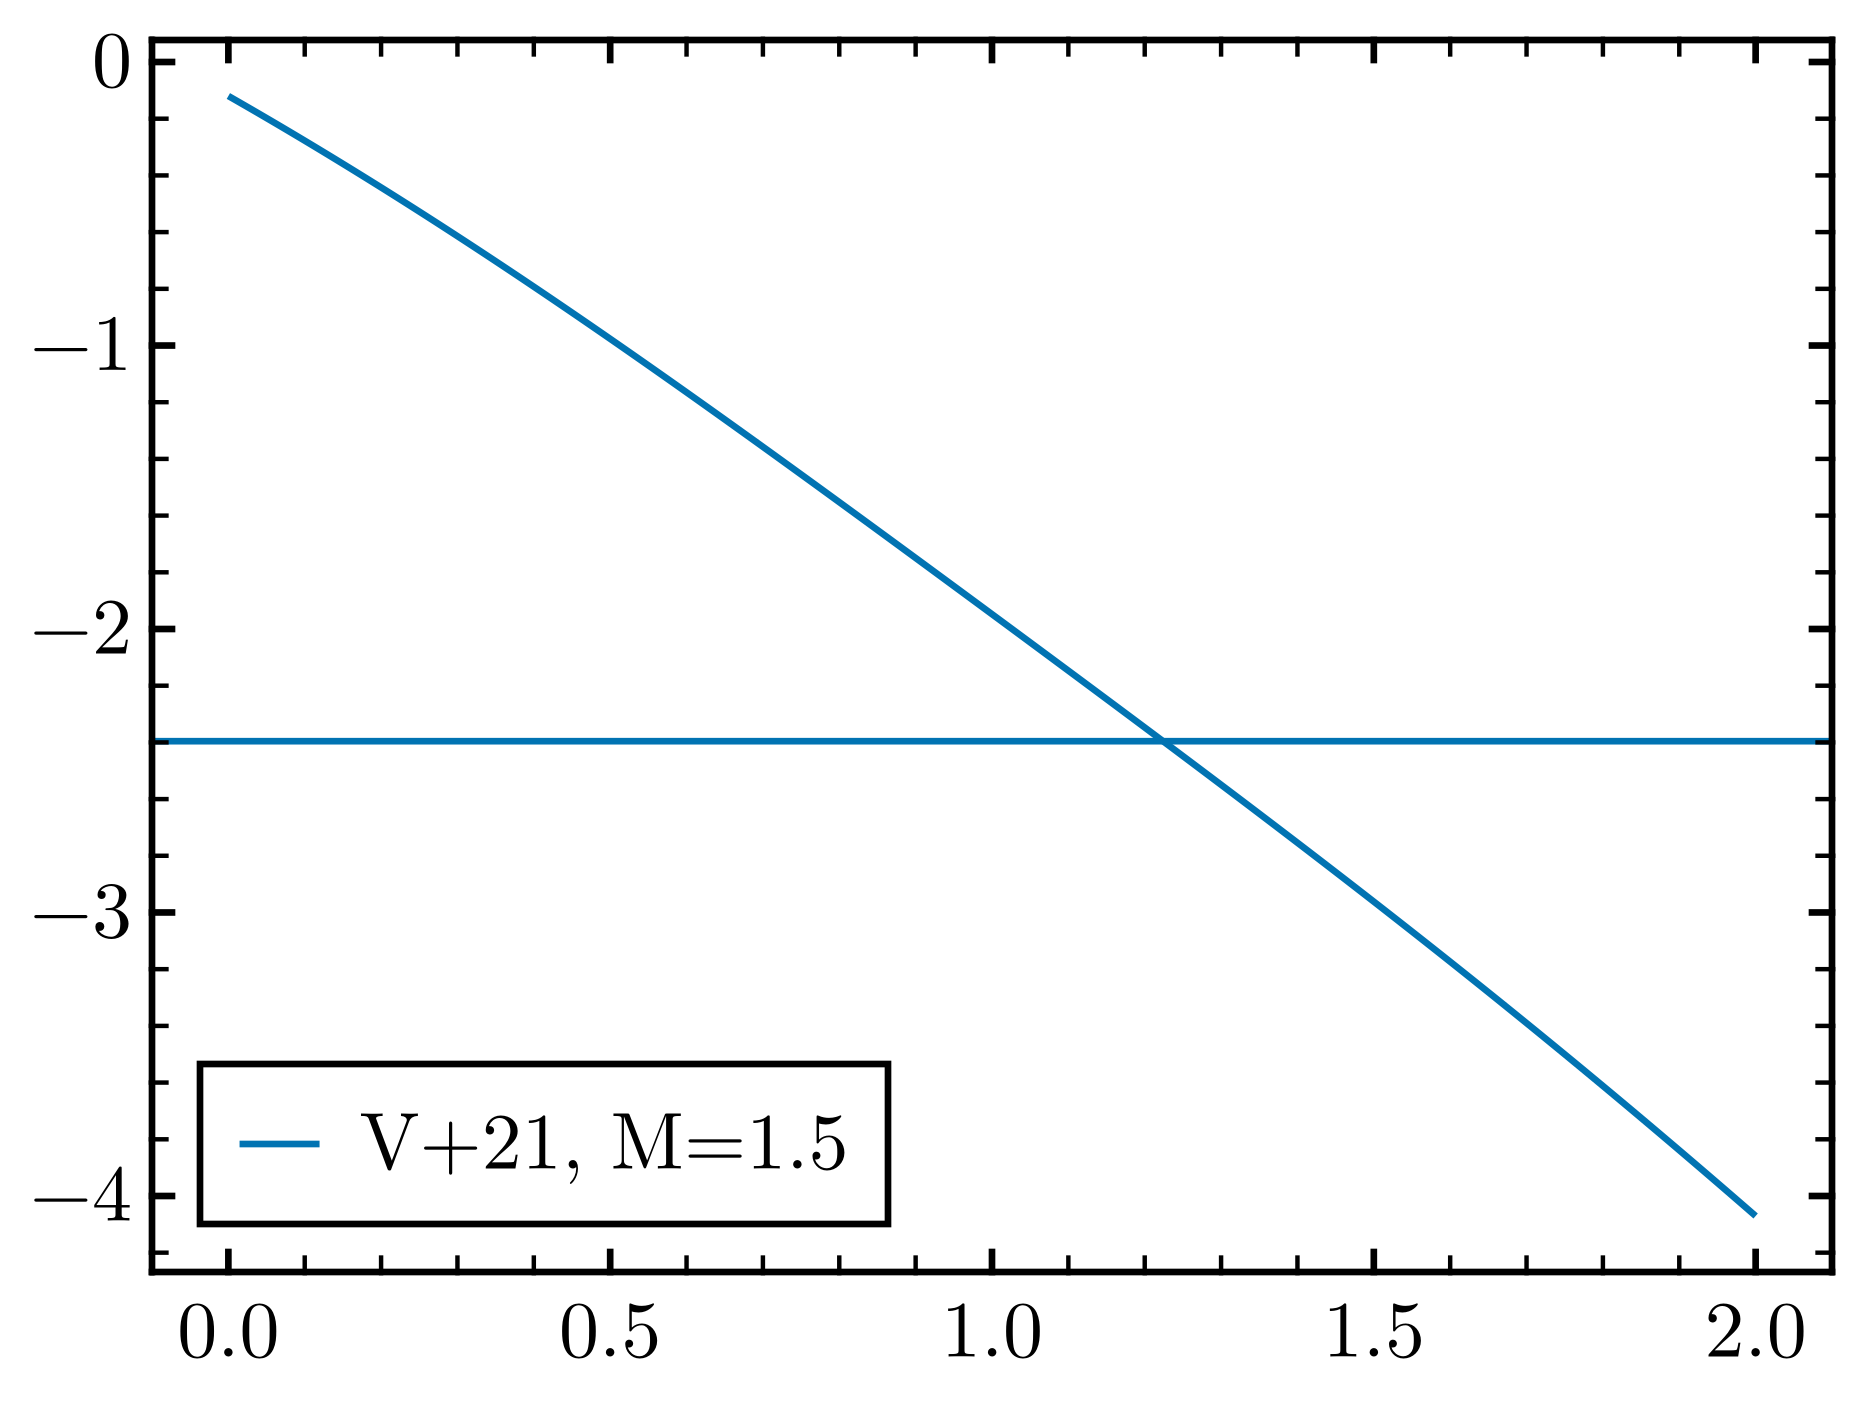

In [73]:
let
    fig = Figure()
    ax = Axis(fig[1,1])

    plot_acc!(ax, pot_EP, xlimits=(0, 2), vasiliev_units=false, label="V+21, M=1.5")

    hlines!(log10.(sv^2 / rh^2))
    axislegend(position=:lb)
    ax
    fig
end

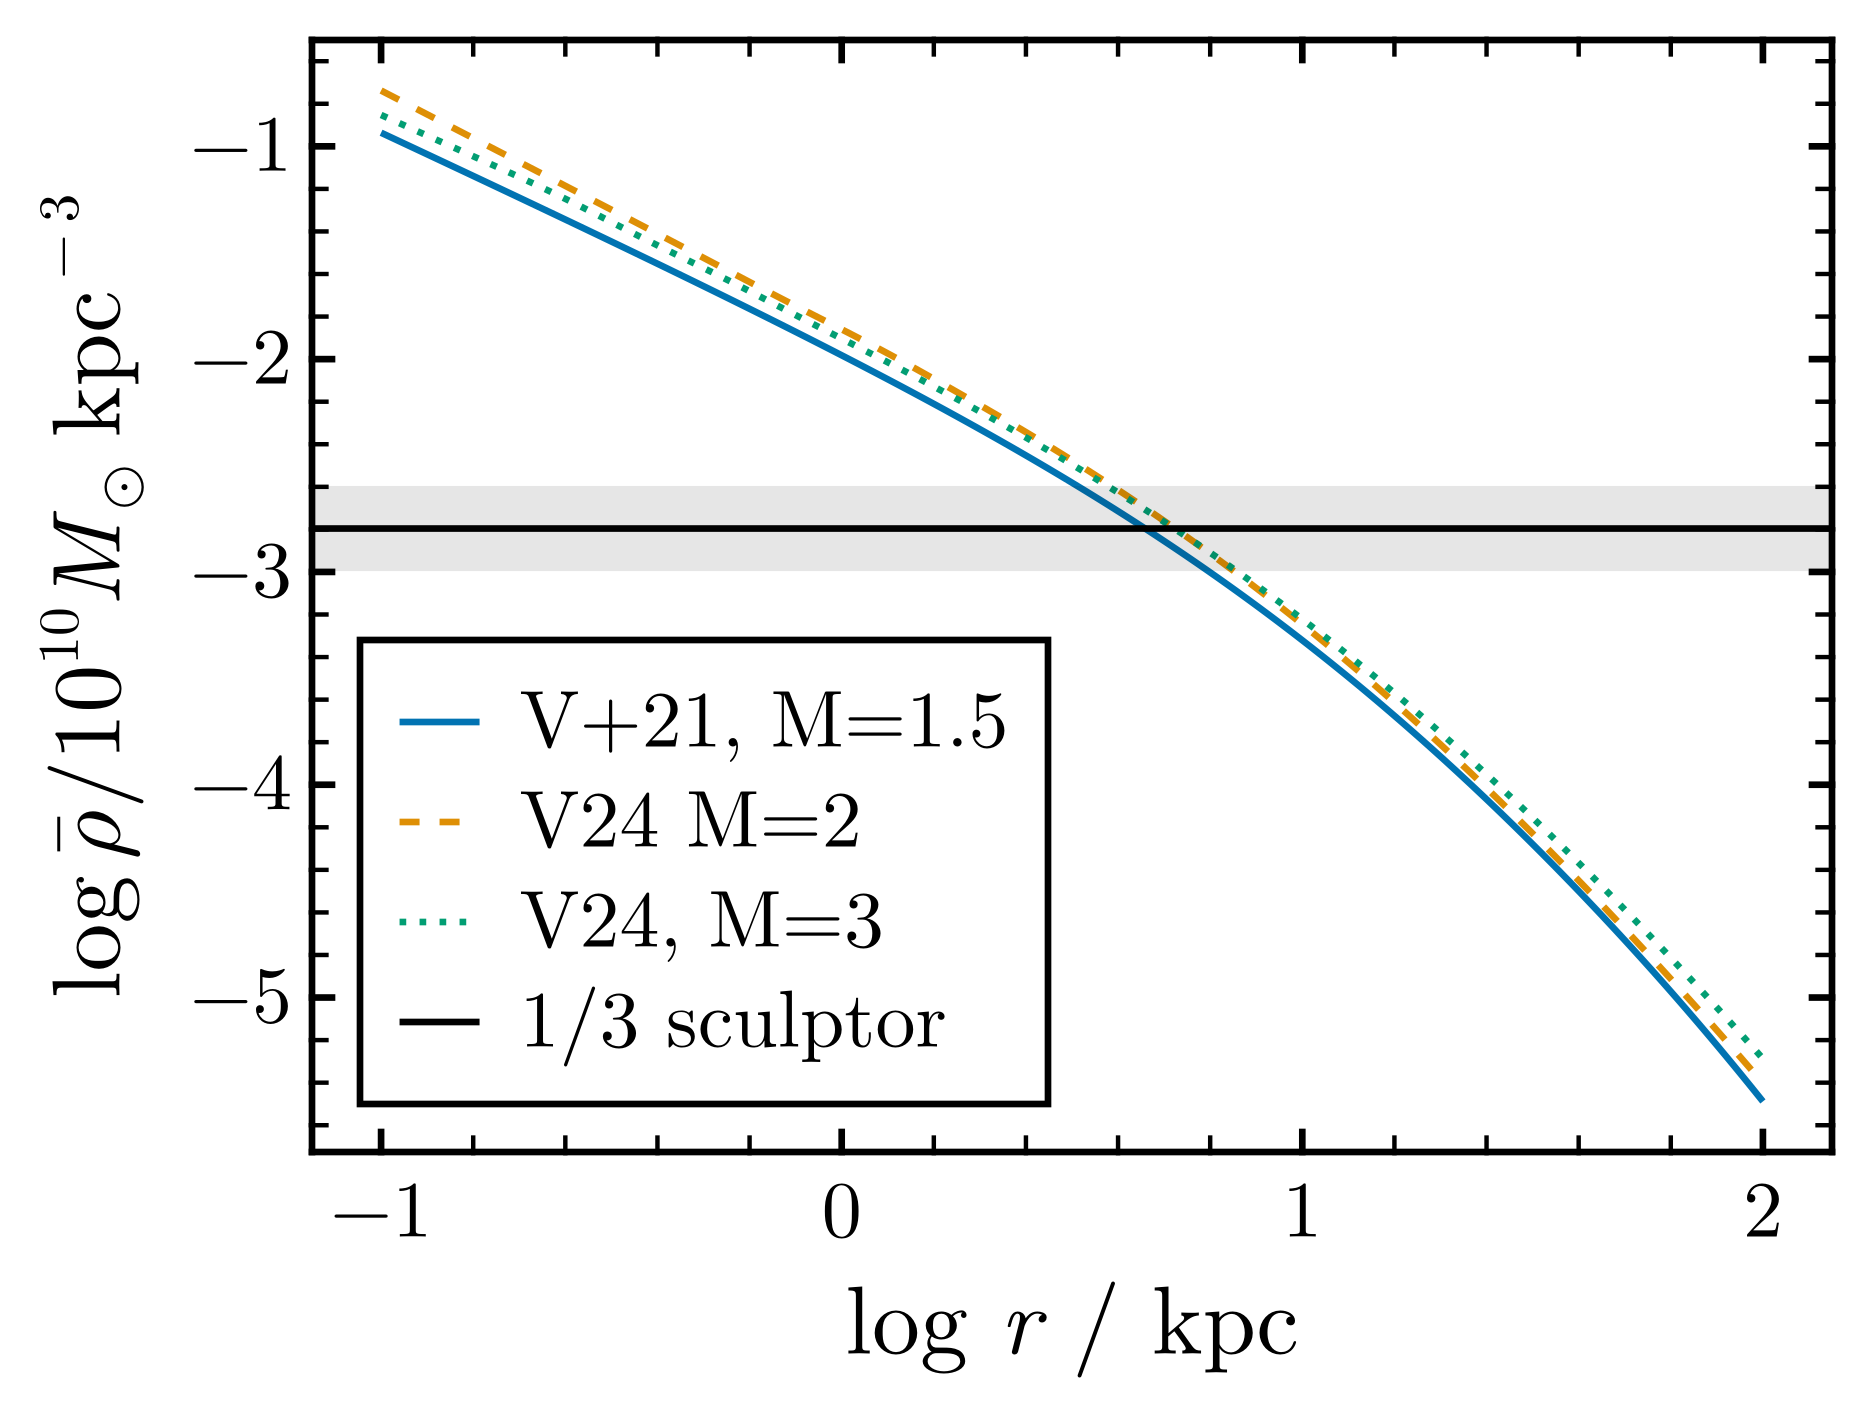

In [74]:
let
    fig = Figure()
    ax = density_axis(fig[1,1])

    plot_ρ_mean!(ax, pot_lmc_1_5, xlimits=(-1, 2), vasiliev_units=true, label="V+21, M=1.5")
    plot_ρ_mean!(ax, pot_lmc_2, xlimits=(-1, 2), vasiliev_units=true, label="V24 M=2")
    plot_ρ_mean!(ax, pot_lmc_3, xlimits=(-1, 2), vasiliev_units=true, label="V24, M=3")

    hlines!(log10(ρ_mean/3), color=:black, label="1/3 sculptor")
    hspan!(log10(ρ_mean/3) - dlρ_mean, log10(ρ_mean/3) + dlρ_mean, color=(:black, 0.1))

    axislegend(position=:lb)
    ax
    fig
end

In [75]:
log10(8.7), log10(1.7/ (8.7^3 * 4π/3))

(0.9395192526186185, -3.2101974457800155)

In [76]:
function calc_rperi_rj(host, satellite; rh=rh, limits=(0, 2), vasiliev_units=false)
    x = LinRange(limits[1], limits[2], 1000)

    r = 10 .^ x

    ρ_mean_host = LilGuys.lerp(r, calc_ρ_mean(host, r, vasiliev_units=vasiliev_units))

    r2 = 10 .^ LinRange(-2, 3, 1000)
    ρ_mean_sat = LilGuys.lerp(r2, calc_ρ_mean(satellite, r2))

    rj = zeros(length(r))

    rperi = r
    
    for i in eachindex(rj)

        rr = rperi[i]
        rj[i] = LilGuys.find_zero(r -> ρ_mean_sat(r) - 3*ρ_mean_host(rr), 1.)
    end

    return rperi, rj
end

    

calc_rperi_rj (generic function with 1 method)

In [77]:
function plot_rperi_rj!(host, satellite; rh=rh, vasiliev_units=false, kwargs...)
    rp, rj = calc_rperi_rj(host, satellite; rh=rh, vasiliev_units=vasiliev_units)

    lines!(log10.(rp), log10.(rj); kwargs...)
end

plot_rperi_rj! (generic function with 1 method)

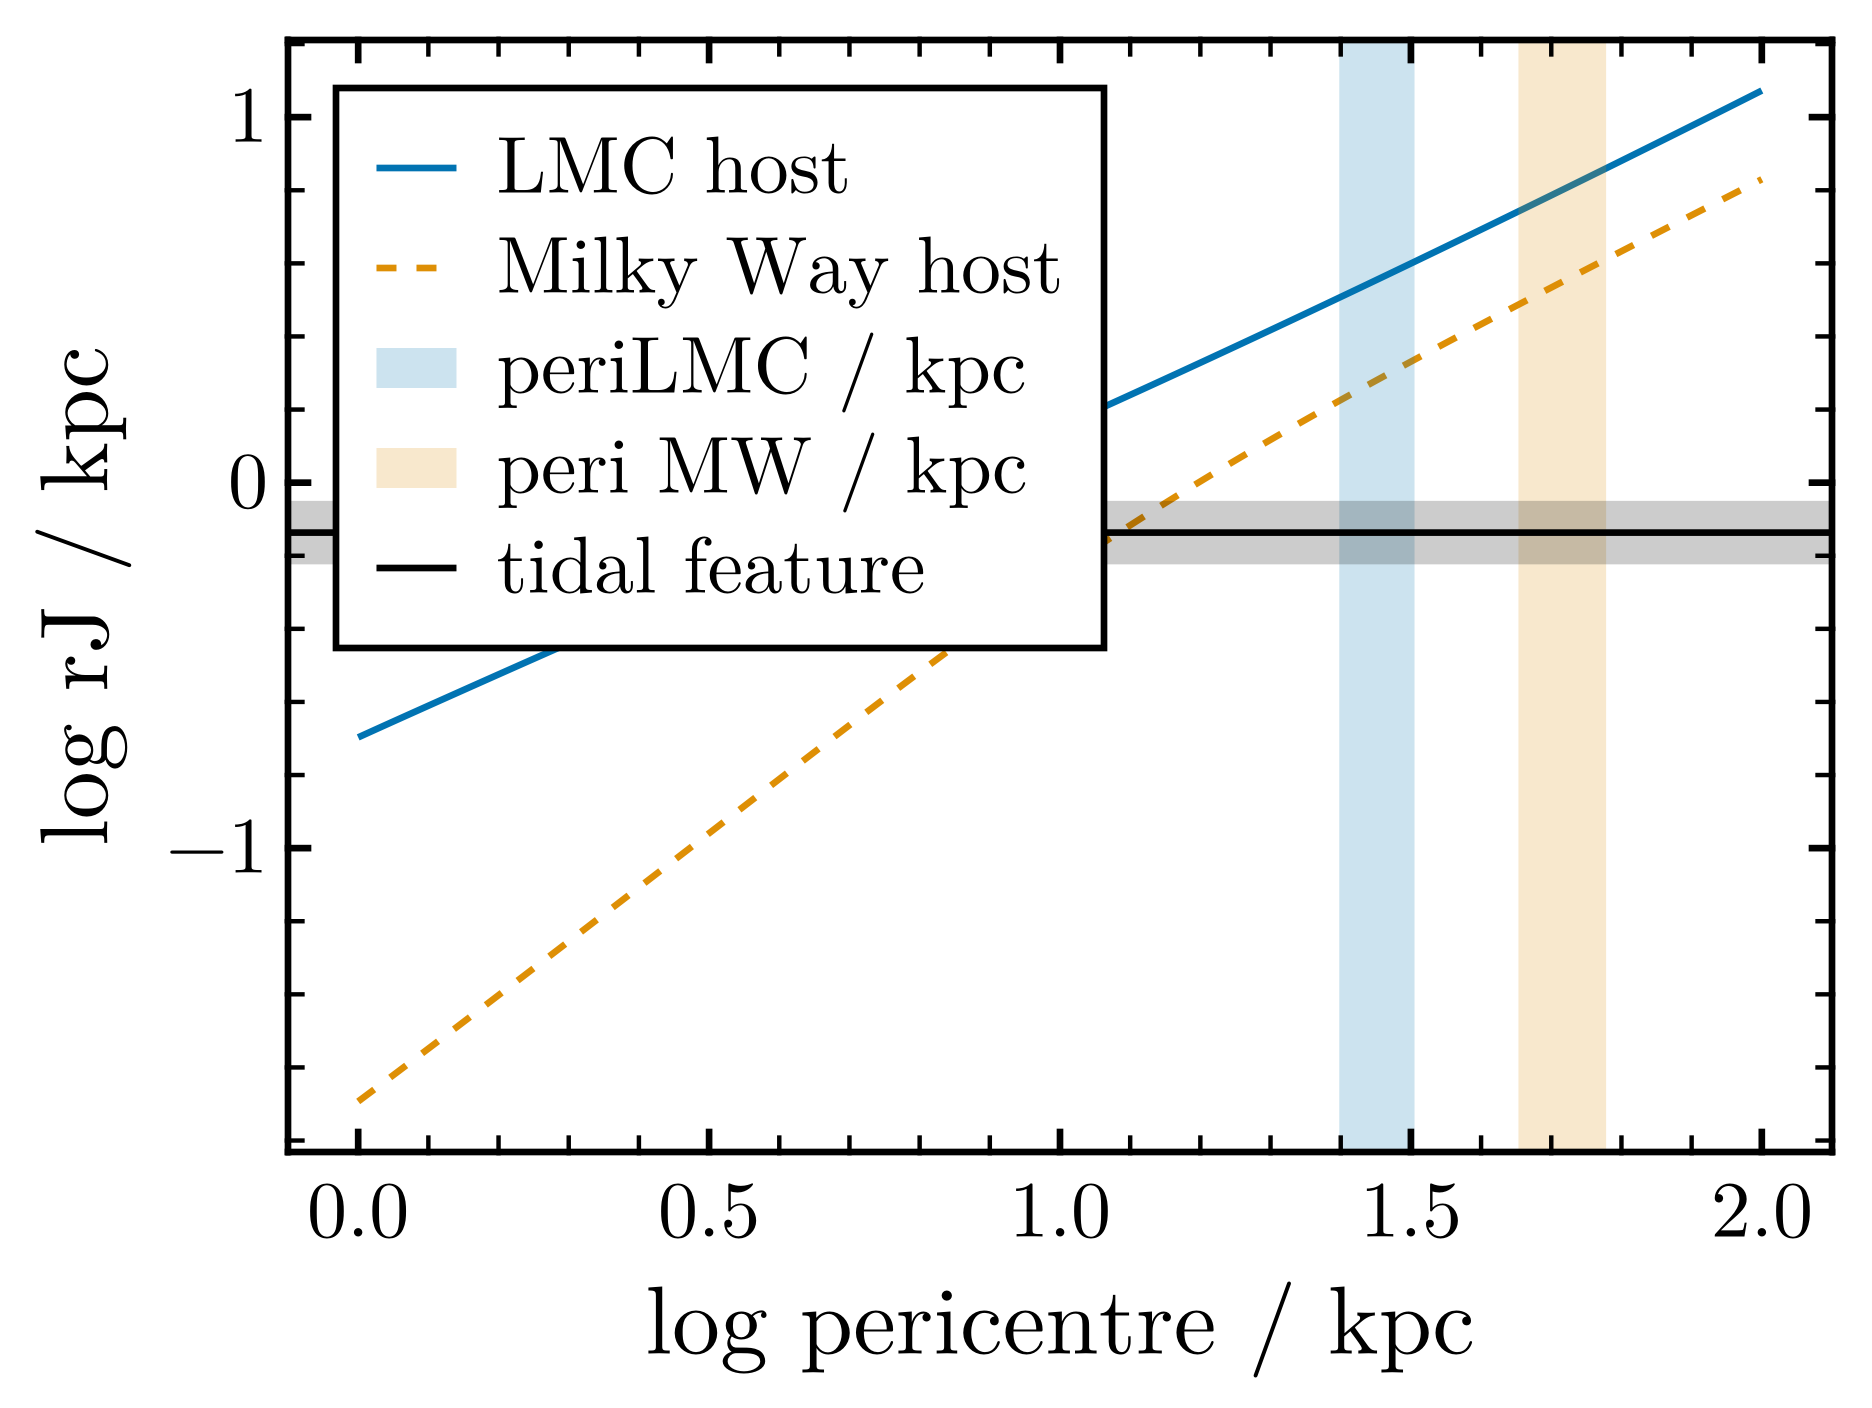

In [78]:
fig = Figure()
ax = Axis(fig[1,1];
    xlabel = "log pericentre / kpc",
    ylabel = "log rJ / kpc",
)

plot_rperi_rj!(pot_lmc_3, scl_profile, vasiliev_units=true, label="LMC host")
plot_rperi_rj!(pot_EP, scl_profile, label="Milky Way host")

vspan!(log10.(25), log10(32), label="periLMC / kpc", color=(COLORS[1], 0.2))
vspan!(log10.(45), log10(60), label="peri MW / kpc", color=(COLORS[2], 0.2))

hlines!(log10(rh), color=:black, label="tidal feature")
hspan!(log10(rh) - 0.05/0.25 / log(10), log10(rh) + 0.05/0.25 / log(10), color=(:black, 0.2))
axislegend(position=:lt)

fig

In [79]:
rp, rj = calc_rperi_rj(pot_EP, scl_profile)

([1.0, 1.0046204213468128, 1.0092621909870476, 1.013925407558815, 1.0186101701559758, 1.023316578330245, 1.0280447320933093, 1.0327947319189517, 1.0375666787451858, 1.0423606739764015  …  95.93608287093141, 96.37934799615786, 96.82466119303123, 97.27203192450543, 97.72146969725725, 98.17298406188836, 98.6265846131282, 99.08228099003797, 99.54008287621524, 100.0], [0.020272218969263876, 0.020406308699338512, 0.020542074428571644, 0.020677794516409668, 0.020815607167710623, 0.020953590773397528, 0.0210928638366287, 0.02123314566165824, 0.021373891607669383, 0.021516506794092505  …  6.490578894531342, 6.5201764769595245, 6.549770730067532, 6.579261555381133, 6.609367141711176, 6.639161279735377, 6.669367650420732, 6.699676847078801, 6.729771675028118, 6.760605406024741])

In [80]:
rp[argmin(abs.(rj .- rh))]

12.1082975023204

In [81]:
rp, rj = calc_rperi_rj(pot_lmc_3, scl_profile, vasiliev_units=true)

([1.0, 1.0046204213468128, 1.0092621909870476, 1.013925407558815, 1.0186101701559758, 1.023316578330245, 1.0280447320933093, 1.0327947319189517, 1.0375666787451858, 1.0423606739764015  …  95.93608287093141, 96.37934799615786, 96.82466119303123, 97.27203192450543, 97.72146969725725, 98.17298406188836, 98.6265846131282, 99.08228099003797, 99.54008287621524, 100.0], [0.20091011922442356, 0.2017223801003548, 0.20253265590488842, 0.20335639765308328, 0.20417602682203362, 0.2049964653804597, 0.205827769029857, 0.20665495852800733, 0.20748571180310513, 0.2083247700243719  …  11.359331177337339, 11.409896929653158, 11.46112381392045, 11.512624749608586, 11.563613564699631, 11.616067285523052, 11.667966717857743, 11.720225665293984, 11.77308493799587, 11.825384722165014])

In [82]:
rp[argmin(abs.(rj .- rh))]

4.556786265841064

In [83]:
rp, rj = calc_rperi_rj(pot_lmc_2, scl_profile, vasiliev_units=true)

([1.0, 1.0046204213468128, 1.0092621909870476, 1.013925407558815, 1.0186101701559758, 1.023316578330245, 1.0280447320933093, 1.0327947319189517, 1.0375666787451858, 1.0423606739764015  …  95.93608287093141, 96.37934799615786, 96.82466119303123, 97.27203192450543, 97.72146969725725, 98.17298406188836, 98.6265846131282, 99.08228099003797, 99.54008287621524, 100.0], [0.18535583131729502, 0.18611737462893502, 0.18687849298122206, 0.18765166246997908, 0.1884214536374172, 0.1891944188654028, 0.18997607216384366, 0.1907543559978165, 0.19153950922363475, 0.19232988700655304  …  12.61010953980109, 12.667798292126408, 12.726702538839499, 12.785439672802282, 12.844232431160197, 12.904037324277027, 12.963193392265186, 13.023598878339874, 13.083829941074097, 13.144132115317426])

In [84]:
rp[argmin(abs.(rj .- rh))]

4.6202413717513116